In [1]:
import numpy as np
import random
from PIL import Image
from matplotlib.pyplot import imshow
from functools import partial
from tqdm import tqdm
import matplotlib.pyplot as plt
from os import walk
from itertools import tee

%matplotlib inline

Указываем глобальные переменные:
- `SEED`: для случайных генераторов с целью воспроизводимости
- `MODE`: режим работы с картинкой **RGB**/**L** - цветной/черно-белый
- `S`: количество аргументов на пиксель (**3** - для цветного изображения, **1** - для черно-белого)
- `IMG_PATH`: путь к обрабатываемому изображению

In [2]:
SEED = 342323425
np.random.seed(SEED)
MODE = 'L'
S = 1
IMG_PATH = './rsz_pic3.jpg'

Метод загрузки картинки и преобразования в необходимый режим и размер

In [3]:
def load_image(path):
    img = Image.open(path)
    img = img.resize((128, 128))
    return img.convert(MODE)

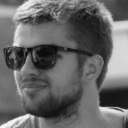

In [4]:
load_image(IMG_PATH)

Инициализация гиперпараметров: 
- `W`: ширина картинки
- `H`: высота картинки
- `n`: размер выреза (длина)
- `m`: размер выреза (ширина)
- `L`: количество нарезанных блоков
- `N`: размер вектора, конвертируемого из нарезанного блока

In [5]:
def init_hyperparams(im):
    W, H = im.size
    n, m = 16, 16
    L = H / n * W / m
    N = n * m * S
    return W, H, n, m, L, N, S

pic = load_image(IMG_PATH)
W, H, n, m, L, N, S = init_hyperparams(pic)
print W, H, L, N, S
# imshow(pic)

128 128 64 256 1


Методы преобразования картинки, генераторы нарезаемых блоков. Картинка равномерно нарезается на блоки последовательно слева-направо и сверху-вниз на размеры nxm. При декодировании следует помнить о том, что в результате должны получиться
- целый знчения
- числа в пределах $[0..255]$

Поэтому делается `np.clip(np.int_(C_MAX * (area + 1.0) / 2.0), 0, 255)`

In [6]:
def encode_pixel(P):
    C_MAX = 255.0
    P = np.array(P)
    return (2.0 * P / C_MAX) - 1.0

def encode_area(im, lu_corner, rb_corner):
    X0, Y0 = lu_corner
    X1, Y1 = rb_corner
    
    def transform(x, y):
        return encode_pixel(im.getpixel((x, y)))
    
    q = []
    for x in range(X0, X1 + 1):
        for y in range(Y0, Y1 + 1):
            q.append(transform(x, y))
    return np.array(q).flatten()

def decode_area(area):
    C_MAX = 255.0
    res = np.clip(np.int_(C_MAX * (area + 1.0) / 2.0), 0, 255)
    return res

def decode_image(areas):
    if S == 1:
        im_area = np.empty((H, W))
    else:
        im_area = np.empty((H, W, S))
    for i in range(H):
        for j in range(W):
            ii = i / n
            jj = j / m
            idx = ii * (W / m) + jj
            im_area[j][i] = decode_area(areas[idx][0][(i % n) * m + j % m:(i % n) * m + j % m + S])
    return Image.fromarray(im_area.astype('uint8'), mode=MODE)

def transform_random_image(im, n, m):
    
    def transform(i, j):
        lu = (i, j)
        rb = (i + n - 1, j + m - 1)
        return encode_area(im, lu, rb)
    
    while True:
        i = np.random.randint(im.height - n)
        j = np.random.randint(im.width - m)
        X = transform(i, j)
        yield X.reshape(1, len(X))
        

def transform_image(im, n, m):
    
    def transform(i, j):
        lu = (i, j)
        rb = (i + n - 1, j + m - 1)
        return encode_area(im, lu, rb)
    
    for i in range(0, im.height, n):
        for j in range(0, im.width, m):
            X = transform(i, j)
            yield X.reshape(1, len(X))

Подсчет коэффициента сжатия

In [7]:
def get_Z(N, L, p):
    return ((N + L) * p + 2.0) / (N * L)

Логика автокодировщика. Здесь используется метод инициализации весов `glorot_uniform` (https://keras.io/initializers/#glorot_uniform and http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf). На вход можно подавать следующие параметры:
- `input_layers`: количество нейронов на входном слое (равно размеру вектора, вычисляемого из нарезанного блока)
- `lr`: learning rate
- `dynamic_lr`: флаг, отвечающий за динамический пересчет learning rate после каждой итерации, либо использовать переданное значение 
- `z`: коэффициент сжатия. Из него вычисляется количество нейронов на втором слое (`int(z * input_layers)`)
- `w_norm`: флаг, отвечающий за нормировку весов после каждой итерации

Вызов автокодировщика прогоняет все блоки картинки (выполняет одну эпоху). Каждую эпоху насчитывается суммарная ошибка на всех обработанных блоках.

In [9]:
def glorot_uniform(input_layers, output_layers):
    limit = np.sqrt(6.0 / (input_layers + output_layers))
    return partial(np.random.uniform, low=-limit, high=limit)

class Autoencoder(object):
    def __init__(self, input_layers=1000, lr=1e-2, dynamic_lr=True, z=0.9, w_norm=True):
        self.input_layers = input_layers
        self.mid_layers = int(z * input_layers)
        self.initializer = glorot_uniform(self.input_layers, self.mid_layers)
        self.lr = lr
        self.w_norm = w_norm
        self.dynamic_lr = dynamic_lr
        self.build()
        
    def error(self, err):
        return err**2
    
    def build(self):
        self.W1 = self.initializer(size=[self.input_layers, self.mid_layers])
        self.W2 = self.W1.T
    
    def __call__(self, gen, pbar=None):
        err = 0.0
        for inp in gen:
            mid, res = self.forward(inp)
            diff = res - inp
            err += self.error(diff).sum()
            self.backward(inp, mid, diff)
            if pbar:
                pbar.update(1)
        return err
    
    def forward(self, inp):
        mid = self.encode(inp, self.W1)
        return mid, self.decode(mid, self.W2)
    
    def backward(self, inp, mid, err):
        lr = self.lr
        if self.dynamic_lr:
            lr = 1.0 / np.dot(inp, inp.T)
        self.W1 -= lr * np.dot(np.dot(inp.T, err), self.W2.T)
        if self.dynamic_lr:
            lr = 1.0 / np.dot(mid, mid.T)
        self.W2 -= lr * np.dot(mid.T, err)
        
        if self.w_norm:
            self.W2 /= np.linalg.norm(self.W2, axis=0, keepdims=True)
            self.W1 /= np.linalg.norm(self.W1, axis=1, keepdims=True)

    def encode(self, inp, W1):
        return np.dot(inp, W1)
    
    def decode(self, mid, W2):
        return np.dot(mid, W2)

Метод для запуска обучения для выбранной модели. Контролируются следующие параметры:
- `model`: настроенная модель
- `epochs`: ограничение сверху на количество запускаемых эпох
- `name`: используется для отрисовки названия графика "Количество эпох на ошибку"
- `th_err`: пороговое значение для ошибки
- `viz`: флаг, нужно ли рисовать график
- `ax`: переданный объект plot, на котором нужно рисовать график (следует передать `viz=True`)
- `gen`: генератор для блоков. По умолчанию генерируются блоки из стандартной картинки размера `n x m`
- `progress`: progress bar для визуализации прогресса
- `L`: количество блоков (используется для progress bar по умолчанию)

Критерий останова: ошибка меньше пороговой либо количество запущенных эпох достигло значения `epochs`. В результат сохраняется следующая информация:

- `W1`, `W2`: веса на первом и втором слое соответственно
- `min_err`: минимальная достигнутая ошибка
- `epoch`: количество прошедших эпох (может быть меньше, чем `epochs`, если была получена ошибка меньше заявленной пороговой, но не может быть больше `epochs`)

In [10]:
def try_run(model, epochs, name='', th_err=0.1, viz=True, ax=None, gen=None, progress=True, L=L):
    np.random.seed(SEED)
    errors = []
    if gen is None:
        im = load_image(IMG_PATH)
        gen = transform_image(im, n, m)
    gens = tee(gen, epochs)
    best_results = {
        'W1': None,
        'W2': None,
        'min_err': np.inf,
        'epoch': epochs,
    }

    def run_iters(pbar=None):
        epoch_run = 0
        err = np.inf
        min_err = np.inf
        cur_gen = 0
        while epoch_run < epochs and err > th_err:
            t_gen = gens[cur_gen]
            cur_gen += 1
            errors.append(model(t_gen, pbar))
            if errors[-1] < min_err:
                best_results['min_err'] = errors[-1]
                best_results['W1'] = model.W1
                best_results['W2'] = model.W2
                min_err = errors[-1]
            err = errors[-1]
            epoch_run += 1

        best_results['epoch'] = epoch_run

    if progress:
        with tqdm(total=epochs*L) as pbar:
            run_iters(pbar)
    else:
        run_iters()
    
    if viz:
        epoch = best_results['epoch']
        x = np.arange(epoch)
        idx = np.argmin(errors)
        print("BEST ERROR {} at {}".format(errors[idx], idx))
        
        if ax is None:
            plt.plot(x, np.array(errors))
            plt.title(name)
            plt.plot(x[idx], errors[idx], 'rx--', linewidth=2, markersize=12)
            plt.show()
        else:
            ax.plot(x, np.array(errors))
            ax.set_title(name)
            ax.plot(x[idx], errors[idx], 'rx--', linewidth=2, markersize=12)
    return best_results
    
def viz_encode(model, best_results, path=IMG_PATH):
    W1 = best_results['W1']
    W2 = best_results['W2']
    min_err = best_results['min_err']
    epoch = best_results['epoch']
    
    print 'Showing results for min_err={}. Epoch run: {}'.format(min_err, epoch)
    areas = []
    im = load_image(path)
    for area in transform_image(im, n, m):
        areas.append(model.decode(model.encode(area, W1), W2))
    areas = np.array(areas)
    new_pic = decode_image(areas)
    return new_pic

Зависимость количества эпох от коэффициента сжатия `Z`. Фиксированные параметры:
- `th_err`: 10.0
- `epochs`: 3000
- `dynamic_lr`: True

  0%|          | 28/192000 [00:00<11:42, 273.16it/s]

running for z=0.95


  0%|          | 42/192000 [00:00<07:45, 412.19it/s]

Error: 9.99581898821
running for z=0.902631578947


  0%|          | 41/192000 [00:00<07:52, 406.30it/s]

Error: 9.99524955959
running for z=0.855263157895


  0%|          | 41/192000 [00:00<08:01, 399.00it/s]

Error: 9.997741394
running for z=0.807894736842


  0%|          | 41/192000 [00:00<07:54, 404.51it/s]

Error: 9.99297610888
running for z=0.760526315789


  0%|          | 47/192000 [00:00<06:49, 468.57it/s]

Error: 9.99848330214
running for z=0.713157894737


  0%|          | 30/192000 [00:00<10:50, 295.21it/s]

Error: 9.99799888912
running for z=0.665789473684


  0%|          | 51/192000 [00:00<06:24, 499.44it/s]

Error: 9.99838696999
running for z=0.618421052632


  0%|          | 49/192000 [00:00<06:36, 484.72it/s]

Error: 9.99645728677
running for z=0.571052631579


  0%|          | 44/192000 [00:00<07:19, 437.16it/s]

Error: 9.998165406
running for z=0.523684210526


  0%|          | 46/192000 [00:00<07:02, 453.84it/s]

Error: 9.99831311216
running for z=0.476315789474


  0%|          | 58/192000 [00:00<05:36, 570.69it/s]

Error: 11.5749577847
running for z=0.428947368421


  0%|          | 49/192000 [00:00<06:33, 487.27it/s]

Error: 14.366996714
running for z=0.381578947368


  0%|          | 59/192000 [00:00<05:33, 574.96it/s]

Error: 19.2026123221
running for z=0.334210526316


  0%|          | 53/192000 [00:00<06:12, 515.59it/s]

Error: 33.459770715
running for z=0.286842105263


  0%|          | 34/192000 [00:00<09:26, 338.84it/s]

Error: 49.6575428267
running for z=0.239473684211


  0%|          | 55/192000 [00:00<05:55, 539.37it/s]

Error: 77.160676679
running for z=0.192105263158


  0%|          | 63/192000 [00:00<05:05, 628.82it/s]

Error: 121.579647134
running for z=0.144736842105


  0%|          | 66/192000 [00:00<04:51, 658.45it/s]

Error: 239.612799344
running for z=0.0973684210526


  0%|          | 83/192000 [00:00<03:51, 829.06it/s]

Error: 258169.464963
running for z=0.05


100%|██████████| 192000/192000 [00:53<00:00, 3613.97it/s]


Error: 5058785.68297


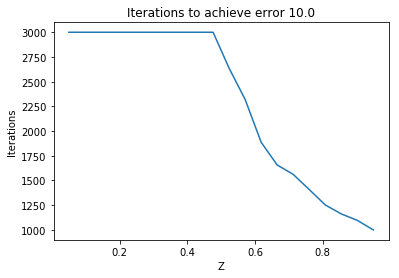

In [145]:
N_z = 20
zs = np.linspace(0.05, 0.95, N_z)
MAX_EPOCHS = 3000
TH_ERR = 10.0

epochs = np.array([])
for z in zs[::-1]:
    print 'running for z={}'.format(z)
    model = Autoencoder(input_layers=N, z=z)
    best_results = try_run(model, MAX_EPOCHS, th_err=TH_ERR, viz=False)
    epochs = np.append(epochs, best_results['epoch'])
    print 'Error:', best_results['min_err']
    
plt.plot(zs[::-1], epochs)
plt.title('Iterations to achieve error {}'.format(TH_ERR))
plt.xlabel('Z')
plt.ylabel('Iterations')
plt.show()

Как видно из приведенного графика, при $Z \leqslant 0.5$ количества эпох в размере $3000$ не хватает, чтобы достичь ошибки в $10.0$, и лишь для следующих коэффициентов это удается сделать. При этом сходится алгоритм значительно быстро - кривая очень наклонена

Построим график заивимости количества эпох от пороговой ошибки. Фиксированные параметры:
- `z`: 0.6
- `epoch`: 3000
- `dynamic_lr`: True

  0%|          | 34/192000 [00:00<09:55, 322.09it/s]

running for thr_err=30.0


 21%|██        | 39936/192000 [00:48<03:04, 822.98it/s]


running for thr_err=27.7777777778


  0%|          | 52/192000 [00:00<06:09, 519.80it/s]

running for thr_err=25.5555555556


  0%|          | 50/192000 [00:00<06:31, 490.76it/s]

running for thr_err=23.3333333333


  0%|          | 48/192000 [00:00<06:44, 474.07it/s]

running for thr_err=21.1111111111


  0%|          | 49/192000 [00:00<06:36, 484.20it/s]

running for thr_err=18.8888888889


  0%|          | 49/192000 [00:00<06:43, 475.51it/s]

running for thr_err=16.6666666667


  0%|          | 47/192000 [00:00<06:51, 466.82it/s]

running for thr_err=14.4444444444


  0%|          | 44/192000 [00:00<07:29, 427.26it/s]

running for thr_err=12.2222222222


  0%|          | 39/192000 [00:00<08:16, 387.00it/s]

running for thr_err=10.0


 71%|███████▏  | 137216/192000 [02:58<01:11, 770.20it/s]


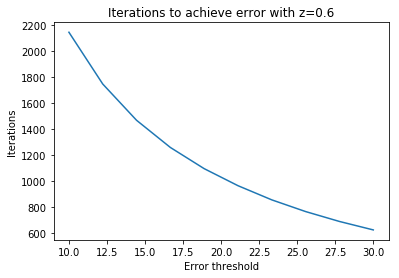

In [147]:
N_thr = 10
thrs = np.linspace(10.0, 30.0, N_thr)
MAX_EPOCHS = 3000
Z = 0.6
epochs = np.array([])
for thr in thrs[::-1]:
    print 'running for thr_err={}'.format(thr)
    model = Autoencoder(input_layers=N, z=Z)
    best_results = try_run(model, MAX_EPOCHS, th_err=thr, viz=False)
    epochs = np.append(epochs, best_results['epoch'])
    
plt.plot(thrs[::-1], epochs)
plt.title('Iterations to achieve error with z={}'.format(Z))
plt.xlabel('Error threshold')
plt.ylabel('Iterations')
plt.show()

Как и ожидалось, количество затраченных эпох до достижения пороговой ошибки гладко снижается

Зависимость количества эпох от коэффициента обучения (`learning rate`). Исходя из проведенных исследований, определим границы для него $[1e^{-6}..1e^{-2}]$. Фиксированные параметры:
- `z`: 0.6
- `th_err`: 10.0
- `epoch`: 3000

  0%|          | 40/192000 [00:00<08:05, 395.29it/s]

running for alpha=0.01


  0%|          | 45/192000 [00:00<07:12, 444.16it/s]

Error:  89399836.4426
running for alpha=0.00947373684211


  0%|          | 44/192000 [00:00<07:21, 434.62it/s]

Error:  88478629.5696
running for alpha=0.00894747368421


  0%|          | 48/192000 [00:00<06:41, 477.96it/s]

Error:  87174296.8514
running for alpha=0.00842121052632


  0%|          | 39/192000 [00:00<08:15, 387.71it/s]

Error:  86681880.4466
running for alpha=0.00789494736842


  0%|          | 45/192000 [00:00<07:07, 448.95it/s]

Error:  30823419.23
running for alpha=0.00736868421053


  0%|          | 46/192000 [00:00<06:58, 458.20it/s]

Error:  30507693.4756
running for alpha=0.00684242105263


  0%|          | 45/192000 [00:00<07:08, 447.84it/s]

Error:  109917.097478
running for alpha=0.00631615789474


  0%|          | 43/192000 [00:00<07:27, 428.87it/s]

Error:  9.76079183172
running for alpha=0.00578989473684


  0%|          | 45/192000 [00:00<07:11, 444.63it/s]

Error:  9.99386879154
running for alpha=0.00526363157895


  0%|          | 47/192000 [00:00<06:56, 461.39it/s]

Error:  9.87008572729
running for alpha=0.00473736842105


  0%|          | 44/192000 [00:00<07:18, 437.32it/s]

Error:  9.99978407562
running for alpha=0.00421110526316


  0%|          | 47/192000 [00:00<06:49, 468.41it/s]

Error:  9.97077184207
running for alpha=0.00368484210526


  0%|          | 44/192000 [00:00<07:18, 438.23it/s]

Error:  9.98614946326
running for alpha=0.00315857894737


  0%|          | 47/192000 [00:00<06:51, 466.46it/s]

Error:  9.96695472801
running for alpha=0.00263231578947


  0%|          | 33/192000 [00:00<09:53, 323.61it/s]

Error:  9.95024961956
running for alpha=0.00210605263158


  0%|          | 48/192000 [00:00<06:40, 478.74it/s]

Error:  9.96597159446
running for alpha=0.00157978947368


  0%|          | 49/192000 [00:00<06:33, 487.93it/s]

Error:  9.97304398247
running for alpha=0.00105352631579


  0%|          | 42/192000 [00:00<07:39, 417.71it/s]

Error:  9.98992659578
running for alpha=0.000527263157895


  0%|          | 46/192000 [00:00<07:05, 451.52it/s]

Error:  9.99676381978
running for alpha=1e-06


100%|██████████| 192000/192000 [04:01<00:00, 795.35it/s]


Error:  512.056742628


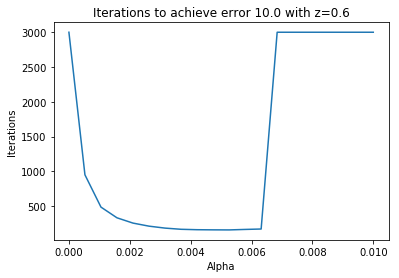

In [148]:
N_alpha = 20
alphas = np.linspace(1e-6, 1e-2, N_alpha)
MAX_EPOCHS = 3000
Z = 0.6
TH_ERR = 10.0
epochs = np.array([])
for alpha in alphas[::-1]:
    print 'running for alpha={}'.format(alpha)
    model = Autoencoder(input_layers=N, z=Z, lr=alpha, dynamic_lr=False)
    best_results = try_run(model, MAX_EPOCHS, th_err=TH_ERR, viz=False)
    epochs = np.append(epochs, best_results['epoch'])
    print 'Error: ', best_results['min_err']
    
plt.plot(alphas[::-1], epochs)
plt.title('Iterations to achieve error {} with z={}'.format(TH_ERR, Z))
plt.xlabel('Alpha')
plt.ylabel('Iterations')
plt.show()

Вывод по этому графику следующий: как и в других похожих алгоритмах обучения (например, в градиентном спуске) существуют две крайности задания `learning rate` ($\alpha$): при слишком низком значении алгоритм "недообучается", то есть показывает плохой результат еще во время обучения, при слишком же большом значении алгоритм "промахивается" мимо глобальных минимумов. Похожая ситуация проявляется и здесь: при слишком маленьком $\alpha$ алгоритму необходимо очень много времени (эпох), чтобы получить хорошую ошибку (график очень резко опускается, если идти слева), затем переходит в зону, в которой $\alpha$ оптимально для обучения (как видно, это достигается где-то при $\alpha = [0.004..0.006]$, затем начинается резкий скачок, когда $\alpha$ лишь делает только хуже всему процессу и выходит из зоны минимума

Зависимость количество эпох от картинки. Всего имеется $8$ картинок, для них и будут проведены тесты.
Фиксированные параметры:
- `z`: 0.6
- `epoch`: 3000
- `th_err`: 70.0
- `dynamic_lr`: True

  0%|          | 34/192000 [00:00<09:26, 338.90it/s]

running for image # 1 cornell_box_04.jpg


  0%|          | 45/192000 [00:00<07:19, 437.03it/s]

Error:  69.8304169301
running for image # 2 Reddeadredemption_agentedgarross_256x256.jpg


  0%|          | 46/192000 [00:00<07:03, 453.71it/s]

Error:  69.9645926085
running for image # 3 Paper Mario.png


  0%|          | 45/192000 [00:00<07:10, 445.71it/s]

Error:  69.9844412457
running for image # 4 Haydn-Jones.jpg


  0%|          | 48/192000 [00:00<06:42, 476.44it/s]

Error:  69.978240198
running for image # 5 NettyScribble.jpg


  0%|          | 45/192000 [00:00<07:11, 444.95it/s]

Error:  69.9098878019
running for image # 6 Avatar_256x256.jpg


  0%|          | 49/192000 [00:00<06:36, 483.98it/s]

Error:  69.9997133819
running for image # 7 img1.jpg


  0%|          | 51/192000 [00:00<06:19, 506.18it/s]

Error:  69.9783549459
running for image # 8 baboon.jpg


  3%|▎         | 5952/192000 [00:06<03:20, 929.79it/s]


Error:  69.3002667239


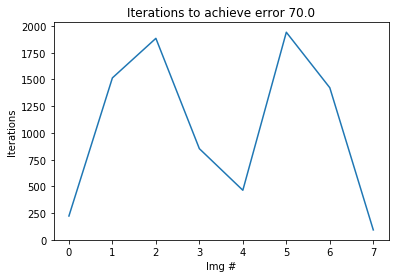

In [151]:
Z = 0.6
MAX_EPOCHS = 3000
TH_ERR = 70.0
epochs = np.array([])
imgs = list(next(walk('./pics/'))[2])

def custom_pic_gen(path):
    im = load_image(path)
    return transform_image(im, n, m)

for idx, img in enumerate(imgs):
    print 'running for image #', idx + 1, img
    model = Autoencoder(input_layers=N, z=Z)
    best_results = try_run(model, MAX_EPOCHS, gen=custom_pic_gen('./pics/{}'.format(img)), th_err=TH_ERR, viz=False)
    epochs = np.append(epochs, best_results['epoch'])
    print 'Error: ', best_results['min_err']
    
plt.plot(range(len(imgs)), epochs)
plt.title('Iterations to achieve error {}'.format(TH_ERR))
plt.xlabel('Img #')
plt.ylabel('Iterations')
plt.show()

Видим, что в зависимости от содержания картинки (много однотонных областей, либо наоборот вся картинка "пестрит") алгоритм обучается неравномерно. Но в целом можно задать верхнюю планку на *время обучения* (в данном случае, где-то в районе 2000 эпох), для которой можно получить требуемую оценку в среднем для всех картинок

Теперь будем варьировать доступные параметры `w_norm` и `dynamic_lr`.

`w_norm`: True

`dynamic_lr`: True:

  0%|          | 28/192000 [00:00<11:42, 273.16it/s]

running for z=0.95


  0%|          | 42/192000 [00:00<07:45, 412.19it/s]

Error: 9.99581898821
running for z=0.902631578947


  0%|          | 41/192000 [00:00<07:52, 406.30it/s]

Error: 9.99524955959
running for z=0.855263157895


  0%|          | 41/192000 [00:00<08:01, 399.00it/s]

Error: 9.997741394
running for z=0.807894736842


  0%|          | 41/192000 [00:00<07:54, 404.51it/s]

Error: 9.99297610888
running for z=0.760526315789


  0%|          | 47/192000 [00:00<06:49, 468.57it/s]

Error: 9.99848330214
running for z=0.713157894737


  0%|          | 30/192000 [00:00<10:50, 295.21it/s]

Error: 9.99799888912
running for z=0.665789473684


  0%|          | 51/192000 [00:00<06:24, 499.44it/s]

Error: 9.99838696999
running for z=0.618421052632


  0%|          | 49/192000 [00:00<06:36, 484.72it/s]

Error: 9.99645728677
running for z=0.571052631579


  0%|          | 44/192000 [00:00<07:19, 437.16it/s]

Error: 9.998165406
running for z=0.523684210526


  0%|          | 46/192000 [00:00<07:02, 453.84it/s]

Error: 9.99831311216
running for z=0.476315789474


  0%|          | 58/192000 [00:00<05:36, 570.69it/s]

Error: 11.5749577847
running for z=0.428947368421


  0%|          | 49/192000 [00:00<06:33, 487.27it/s]

Error: 14.366996714
running for z=0.381578947368


  0%|          | 59/192000 [00:00<05:33, 574.96it/s]

Error: 19.2026123221
running for z=0.334210526316


  0%|          | 53/192000 [00:00<06:12, 515.59it/s]

Error: 33.459770715
running for z=0.286842105263


  0%|          | 34/192000 [00:00<09:26, 338.84it/s]

Error: 49.6575428267
running for z=0.239473684211


  0%|          | 55/192000 [00:00<05:55, 539.37it/s]

Error: 77.160676679
running for z=0.192105263158


  0%|          | 63/192000 [00:00<05:05, 628.82it/s]

Error: 121.579647134
running for z=0.144736842105


  0%|          | 66/192000 [00:00<04:51, 658.45it/s]

Error: 239.612799344
running for z=0.0973684210526


  0%|          | 83/192000 [00:00<03:51, 829.06it/s]

Error: 258169.464963
running for z=0.05


100%|██████████| 192000/192000 [00:53<00:00, 3613.97it/s]


Error: 5058785.68297


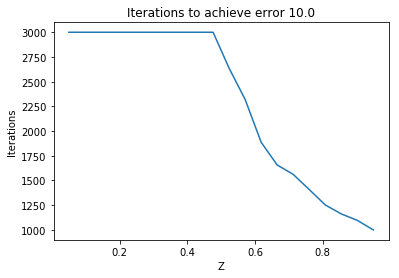

In [145]:
N_z = 20
zs = np.linspace(0.05, 0.95, N_z)
MAX_EPOCHS = 3000
TH_ERR = 10.0

epochs = np.array([])
for z in zs[::-1]:
    print 'running for z={}'.format(z)
    model = Autoencoder(input_layers=N, z=z)
    best_results = try_run(model, MAX_EPOCHS, th_err=TH_ERR, viz=False)
    epochs = np.append(epochs, best_results['epoch'])
    print 'Error:', best_results['min_err']
    
plt.plot(zs[::-1], epochs)
plt.title('Iterations to achieve error {}'.format(TH_ERR))
plt.xlabel('Z')
plt.ylabel('Iterations')
plt.show()

`w_norm`: False

`dynamic_lr`: True

  0%|          | 24/192000 [00:00<13:21, 239.51it/s]

running for z=0.95


  0%|          | 14/192000 [00:00<23:52, 134.00it/s]

Error: 9.98964050661
running for z=0.902631578947


  0%|          | 31/192000 [00:00<10:27, 306.15it/s]

Error: 9.99424755489
running for z=0.855263157895


  0%|          | 51/192000 [00:00<06:23, 500.53it/s]

Error: 9.99179146477
running for z=0.807894736842


  0%|          | 53/192000 [00:00<06:04, 525.96it/s]

Error: 9.99774378037
running for z=0.760526315789


  0%|          | 57/192000 [00:00<05:39, 564.70it/s]

Error: 9.99472224237
running for z=0.713157894737


  0%|          | 56/192000 [00:00<05:46, 553.38it/s]

Error: 9.99434606803
running for z=0.665789473684


  0%|          | 56/192000 [00:00<05:55, 540.26it/s]

Error: 9.99656238184
running for z=0.618421052632


  0%|          | 51/192000 [00:00<06:19, 506.15it/s]

Error: 9.99907645517
running for z=0.571052631579


 53%|█████▎    | 101440/192000 [01:22<01:13, 1225.23it/s]


Error: 9.99474598343
running for z=0.523684210526


  0%|          | 55/192000 [00:00<05:50, 547.44it/s]

Error: 9.99507424991
running for z=0.476315789474


  0%|          | 60/192000 [00:00<05:20, 598.60it/s]

Error: 9.99809594991
running for z=0.428947368421


  0%|          | 61/192000 [00:00<05:17, 604.41it/s]

Error: 9.99602674591
running for z=0.381578947368


  0%|          | 78/192000 [00:00<04:07, 775.19it/s]

Error: 9.99775613519
running for z=0.334210526316


  0%|          | 71/192000 [00:00<04:30, 709.97it/s]

Error: 10.8165762891
running for z=0.286842105263


  0%|          | 72/192000 [00:00<04:27, 718.78it/s]

Error: 12.6934303496
running for z=0.239473684211


  0%|          | 82/192000 [00:00<03:54, 819.24it/s]

Error: 16.5669191555
running for z=0.192105263158


  0%|          | 103/192000 [00:00<03:06, 1028.75it/s]

Error: 22.9261415158
running for z=0.144736842105


  0%|          | 143/192000 [00:00<02:14, 1429.80it/s]

Error: 34.7288629207
running for z=0.0973684210526


  0%|          | 180/192000 [00:00<01:46, 1799.64it/s]

Error: 70.6054886851
running for z=0.05


100%|██████████| 192000/192000 [00:39<00:00, 4871.64it/s]


Error: 191.778419575


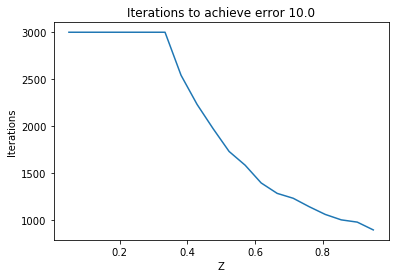

In [19]:
N_z = 20
zs = np.linspace(0.05, 0.95, N_z)
MAX_EPOCHS = 3000
TH_ERR = 10.0

epochs = np.array([])
for z in zs[::-1]:
    print 'running for z={}'.format(z)
    model = Autoencoder(input_layers=N, z=z, w_norm=False)
    best_results = try_run(model, MAX_EPOCHS, th_err=TH_ERR, viz=False)
    epochs = np.append(epochs, best_results['epoch'])
    print 'Error:', best_results['min_err']
    
plt.plot(zs[::-1], epochs)
plt.title('Iterations to achieve error {}'.format(TH_ERR))
plt.xlabel('Z')
plt.ylabel('Iterations')
plt.show()

Без нормализации весов ошибка на небольших коэффициентах сжатия значительно лучше, чем со включенной нормализацией. Помимо прочего, сходимость на более высоких значениях `Z` также быстрее

`w_norm`: False

`dynamic_lr`: False ($\alpha = 0.005$)

  0%|          | 0/192000 [00:00<?, ?it/s]

running for z=0.95


  0%|          | 43/192000 [00:00<07:34, 422.52it/s]

Error: 9.92595090666
running for z=0.902631578947


  0%|          | 45/192000 [00:00<07:07, 448.57it/s]

Error: 9.94448285123
running for z=0.855263157895


  0%|          | 46/192000 [00:00<06:58, 458.14it/s]

Error: 9.86014520636
running for z=0.807894736842


  0%|          | 46/192000 [00:00<07:01, 455.35it/s]

Error: 9.91217507424
running for z=0.760526315789


  0%|          | 46/192000 [00:00<07:01, 455.36it/s]

Error: 9.97469822145
running for z=0.713157894737


  0%|          | 39/192000 [00:00<08:22, 382.24it/s]

Error: 9.9410151547
running for z=0.665789473684


  0%|          | 49/192000 [00:00<06:34, 485.99it/s]

Error: 9.91253757493
running for z=0.618421052632


  0%|          | 50/192000 [00:00<06:25, 498.13it/s]

Error: 9.93167008611
running for z=0.571052631579


  0%|          | 57/192000 [00:00<05:38, 567.00it/s]

Error: 9.93716437249
running for z=0.523684210526


  0%|          | 56/192000 [00:00<05:45, 556.06it/s]

Error: 9.95483636238
running for z=0.476315789474


  0%|          | 53/192000 [00:00<06:07, 522.93it/s]

Error: 9.96648115806
running for z=0.428947368421


  0%|          | 61/192000 [00:00<05:16, 605.81it/s]

Error: 9.96362587588
running for z=0.381578947368


  0%|          | 62/192000 [00:00<05:12, 613.65it/s]

Error: 9.99972739689
running for z=0.334210526316


  0%|          | 62/192000 [00:00<05:11, 616.39it/s]

Error: 9.9662877856
running for z=0.286842105263


  0%|          | 63/192000 [00:00<05:06, 625.53it/s]

Error: 9.98841607564
running for z=0.239473684211


  0%|          | 84/192000 [00:00<03:48, 839.06it/s]

Error: 9.99775669851
running for z=0.192105263158


  0%|          | 98/192000 [00:00<03:16, 977.18it/s]

Error: 9.98176346676
running for z=0.144736842105


  0%|          | 130/192000 [00:00<02:27, 1298.64it/s]

Error: 9.99795329629
running for z=0.0973684210526


  0%|          | 179/192000 [00:00<01:47, 1789.60it/s]

Error: 32.5754540626
running for z=0.05


100%|██████████| 192000/192000 [00:37<00:00, 5130.64it/s]


Error: 123.427264027


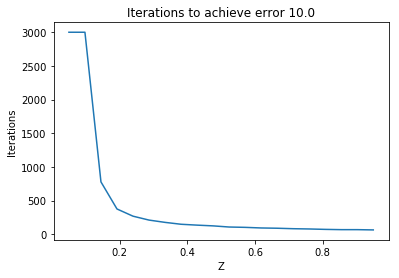

In [29]:
N_z = 20
zs = np.linspace(0.05, 0.95, N_z)
MAX_EPOCHS = 3000
TH_ERR = 10.0

epochs = np.array([])
for z in zs[::-1]:
    print 'running for z={}'.format(z)
    model = Autoencoder(input_layers=N, z=z, w_norm=False, dynamic_lr=False, lr=0.005)
    best_results = try_run(model, MAX_EPOCHS, th_err=TH_ERR, viz=False)
    epochs = np.append(epochs, best_results['epoch'])
    print 'Error:', best_results['min_err']
    
plt.plot(zs[::-1], epochs)
plt.title('Iterations to achieve error {}'.format(TH_ERR))
plt.xlabel('Z')
plt.ylabel('Iterations')
plt.show()

С правильно подобранным $\alpha$ результат становится еще лучше (быстрее сходится и в целом, и на малых `Z`)

`w_norm`: True

`dynamic_lr`: False ($\alpha = 0.005$)

  0%|          | 32/192000 [00:00<10:05, 316.89it/s]

running for z=0.95


  0%|          | 33/192000 [00:00<09:51, 324.77it/s]

Error: 9.9131313894
running for z=0.902631578947


  0%|          | 27/192000 [00:00<12:27, 256.84it/s]

Error: 9.8837381121
running for z=0.855263157895


  0%|          | 32/192000 [00:00<10:02, 318.47it/s]

Error: 9.98663027636
running for z=0.807894736842


  0%|          | 42/192000 [00:00<07:44, 413.32it/s]

Error: 9.91820674508
running for z=0.760526315789


  0%|          | 26/192000 [00:00<12:43, 251.54it/s]

Error: 9.96758856182
running for z=0.713157894737


  0%|          | 38/192000 [00:00<08:36, 371.94it/s]

Error: 9.96732347235
running for z=0.665789473684


  0%|          | 40/192000 [00:00<08:05, 395.09it/s]

Error: 9.95993551898
running for z=0.618421052632


  0%|          | 30/192000 [00:00<11:13, 285.12it/s]

Error: 9.96703082353
running for z=0.571052631579


  0%|          | 47/192000 [00:00<06:49, 469.21it/s]

Error: 9.93409072964
running for z=0.523684210526


  0%|          | 44/192000 [00:00<07:17, 438.80it/s]

Error: 9.99606158828
running for z=0.476315789474


  0%|          | 52/192000 [00:00<06:11, 516.24it/s]

Error: 9.91811931371
running for z=0.428947368421


  0%|          | 52/192000 [00:00<06:14, 512.46it/s]

Error: 9.9986093364
running for z=0.381578947368


  0%|          | 53/192000 [00:00<06:06, 523.82it/s]

Error: 9.97146726304
running for z=0.334210526316


  0%|          | 57/192000 [00:00<05:39, 564.67it/s]

Error: 90449.070168
running for z=0.286842105263


  0%|          | 58/192000 [00:00<05:34, 573.33it/s]

Error: 30691403.2282
running for z=0.239473684211


  0%|          | 63/192000 [00:00<05:08, 622.33it/s]

Error: 30652236.9118
running for z=0.192105263158


  0%|          | 63/192000 [00:00<05:07, 625.14it/s]

Error: 86389392.1948
running for z=0.144736842105


  0%|          | 78/192000 [00:00<04:06, 778.49it/s]

Error: 91911018.2061
running for z=0.0973684210526


  0%|          | 94/192000 [00:00<03:24, 938.97it/s]

Error: 98529011.6745
running for z=0.05


100%|██████████| 192000/192000 [00:54<00:00, 3540.17it/s]


Error: 102181168.197


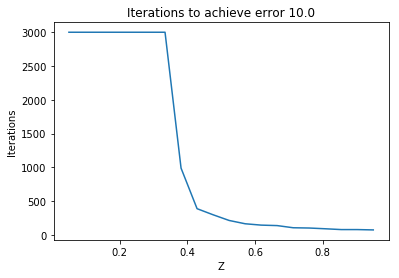

In [28]:
N_z = 20
zs = np.linspace(0.05, 0.95, N_z)
MAX_EPOCHS = 3000
TH_ERR = 10.0

epochs = np.array([])
for z in zs[::-1]:
    print 'running for z={}'.format(z)
    model = Autoencoder(input_layers=N, z=z, w_norm=True, dynamic_lr=False, lr=0.005)
    best_results = try_run(model, MAX_EPOCHS, th_err=TH_ERR, viz=False)
    epochs = np.append(epochs, best_results['epoch'])
    print 'Error:', best_results['min_err']
    
plt.plot(zs[::-1], epochs)
plt.title('Iterations to achieve error {}'.format(TH_ERR))
plt.xlabel('Z')
plt.ylabel('Iterations')
plt.show()

С нормировкой весов и фиксированным $\alpha$ наблюдается резкий скачок в районе $Z \approx 0.4$ к быстрейшей сходимости

Построим зависимости сходимости от пробега по $\alpha$:

  0%|          | 0/192000 [00:00<?, ?it/s]

running for alpha=0.01
Error:  inf
running for alpha=0.00947373684211


  0%|          | 46/192000 [00:00<06:58, 458.85it/s]

Error:  inf
running for alpha=0.00894747368421


  0%|          | 38/192000 [00:00<08:34, 372.78it/s]

Error:  9.80886233081
running for alpha=0.00842121052632


  0%|          | 48/192000 [00:00<06:42, 477.47it/s]

Error:  9.92261877779
running for alpha=0.00789494736842


  0%|          | 36/192000 [00:00<09:00, 355.31it/s]

Error:  9.9789332273
running for alpha=0.00736868421053


  0%|          | 50/192000 [00:00<06:27, 495.42it/s]

Error:  9.89439765325
running for alpha=0.00684242105263


  0%|          | 35/192000 [00:00<09:13, 346.85it/s]

Error:  9.96153964232
running for alpha=0.00631615789474


  0%|          | 47/192000 [00:00<06:51, 466.11it/s]

Error:  9.88606615225
running for alpha=0.00578989473684


  0%|          | 49/192000 [00:00<06:33, 487.38it/s]

Error:  9.92576178844
running for alpha=0.00526363157895


  0%|          | 41/192000 [00:00<08:02, 398.15it/s]

Error:  9.90966402867
running for alpha=0.00473736842105


  0%|          | 42/192000 [00:00<07:47, 410.61it/s]

Error:  9.97829085851
running for alpha=0.00421110526316


  0%|          | 51/192000 [00:00<06:19, 505.99it/s]

Error:  9.97102422667
running for alpha=0.00368484210526


  0%|          | 49/192000 [00:00<06:34, 486.65it/s]

Error:  9.97304148298
running for alpha=0.00315857894737


  0%|          | 48/192000 [00:00<06:45, 473.32it/s]

Error:  9.9333958673
running for alpha=0.00263231578947


  0%|          | 52/192000 [00:00<06:09, 519.61it/s]

Error:  9.97233315925
running for alpha=0.00210605263158


  0%|          | 49/192000 [00:00<06:34, 486.17it/s]

Error:  9.95839812525
running for alpha=0.00157978947368


  0%|          | 49/192000 [00:00<06:31, 489.74it/s]

Error:  9.96758570776
running for alpha=0.00105352631579


  0%|          | 53/192000 [00:00<06:03, 528.69it/s]

Error:  9.99653731066
running for alpha=0.000527263157895


  0%|          | 51/192000 [00:00<06:18, 507.59it/s]

Error:  9.98936437519
running for alpha=1e-06


100%|██████████| 192000/192000 [02:37<00:00, 1222.83it/s]


Error:  385.362267498


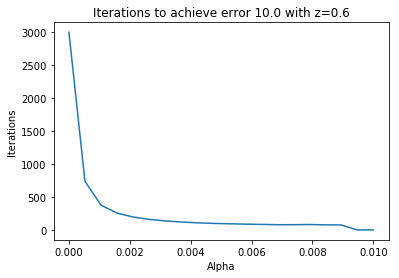

In [24]:
N_alpha = 20
alphas = np.linspace(1e-6, 1e-2, N_alpha)
MAX_EPOCHS = 3000
Z = 0.6
TH_ERR = 10.0
epochs = np.array([])
for alpha in alphas[::-1]:
    print 'running for alpha={}'.format(alpha)
    model = Autoencoder(input_layers=N, z=Z, lr=alpha, w_norm=False, dynamic_lr=False)
    best_results = try_run(model, MAX_EPOCHS, th_err=TH_ERR, viz=False)
    epochs = np.append(epochs, best_results['epoch'])
    print 'Error: ', best_results['min_err']
    
plt.plot(alphas[::-1], epochs)
plt.title('Iterations to achieve error {} with z={}'.format(TH_ERR, Z))
plt.xlabel('Alpha')
plt.ylabel('Iterations')
plt.show()

  0%|          | 39/64000 [00:00<02:49, 378.13it/s]

running for alpha=0.01


  0%|          | 44/64000 [00:00<02:26, 437.60it/s]

Error:  89399836.4426
running for alpha=0.00947373684211


  0%|          | 41/64000 [00:00<02:36, 408.56it/s]

Error:  88478629.5696
running for alpha=0.00894747368421


  0%|          | 40/64000 [00:00<02:42, 393.99it/s]

Error:  87174296.8514
running for alpha=0.00842121052632


  0%|          | 46/64000 [00:00<02:19, 457.00it/s]

Error:  86681880.4466
running for alpha=0.00789494736842


  0%|          | 46/64000 [00:00<02:20, 455.65it/s]

Error:  30823419.23
running for alpha=0.00736868421053


  0%|          | 45/64000 [00:00<02:24, 444.05it/s]

Error:  30507693.4756
running for alpha=0.00684242105263


  0%|          | 45/64000 [00:00<02:22, 449.43it/s]

Error:  109917.097478
running for alpha=0.00631615789474


  0%|          | 46/64000 [00:00<02:21, 452.94it/s]

Error:  9.76079183172
running for alpha=0.00578989473684


  0%|          | 45/64000 [00:00<02:23, 445.14it/s]

Error:  9.99386879154
running for alpha=0.00526363157895


  0%|          | 46/64000 [00:00<02:20, 455.08it/s]

Error:  9.87008572729
running for alpha=0.00473736842105


  0%|          | 45/64000 [00:00<02:23, 446.93it/s]

Error:  9.99978407562
running for alpha=0.00421110526316


  0%|          | 47/64000 [00:00<02:17, 465.00it/s]

Error:  9.97077184207
running for alpha=0.00368484210526


  0%|          | 45/64000 [00:00<02:22, 448.52it/s]

Error:  9.98614946326
running for alpha=0.00315857894737


  0%|          | 34/64000 [00:00<03:08, 339.46it/s]

Error:  9.96695472801
running for alpha=0.00263231578947


  0%|          | 46/64000 [00:00<02:20, 456.32it/s]

Error:  9.95024961956
running for alpha=0.00210605263158


  0%|          | 46/64000 [00:00<02:21, 452.69it/s]

Error:  9.96597159446
running for alpha=0.00157978947368


  0%|          | 45/64000 [00:00<02:27, 434.64it/s]

Error:  9.97304398247
running for alpha=0.00105352631579


  0%|          | 46/64000 [00:00<02:20, 455.87it/s]

Error:  9.98992659578
running for alpha=0.000527263157895


  0%|          | 46/64000 [00:00<02:19, 457.02it/s]

Error:  9.99676381978
running for alpha=1e-06


100%|██████████| 64000/64000 [01:11<00:00, 889.58it/s]


Error:  912.194453446


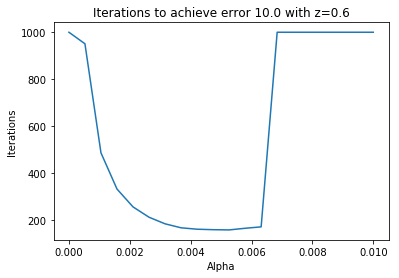

In [27]:
N_alpha = 20
alphas = np.linspace(1e-6, 1e-2, N_alpha)
MAX_EPOCHS = 1000
Z = 0.6
TH_ERR = 10.0
epochs = np.array([])
for alpha in alphas[::-1]:
    print 'running for alpha={}'.format(alpha)
    model = Autoencoder(input_layers=N, z=Z, lr=alpha, w_norm=True, dynamic_lr=False)
    best_results = try_run(model, MAX_EPOCHS, th_err=TH_ERR, viz=False)
    epochs = np.append(epochs, best_results['epoch'])
    print 'Error: ', best_results['min_err']
    
plt.plot(alphas[::-1], epochs)
plt.title('Iterations to achieve error {} with z={}'.format(TH_ERR, Z))
plt.xlabel('Alpha')
plt.ylabel('Iterations')
plt.show()

Видно, что без нормировки сходится лучше на больших значениях коэффициента сжатия ($Z \approx 0.002-0.09$), в то время как нормировка усугубляет этот интервал до $Z \approx 0.004-0.005$

# Выводы

Реализована рециркуляционная сеть как модель автокодировщика для задачи понижения размерности данных. Получены следующие результаты:
- Алгоритм выполняет меньшее число итераций с увеличением минимальной ошибки
- Алгоритм быстрее сходится при хорошо подобранном шаге обучения ($\approx 0.005$). Адапативный шаг также работает неплохо, но все же при правильно подобранном $\alpha$ можно добиться лучших результатов/скорости
- Применение техник нормирования и адаптивного обучения сокращает число итераций не всегда помогает. Это, в целом, зависит и от начального задания матриц весов
- С уменьшением числа входов/выходов уменьшается время работы алгоритма